In [1]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(emmeans))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(lmerTest))
suppressPackageStartupMessages(library(msigdbr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(data.table))

Warning message:
“package ‘scuttle’ was built under R version 4.1.2”
Warning message:
“package ‘msigdbr’ was built under R version 4.1.3”


In [2]:
setwd("/rds/general/user/emacdona/projects/covid19-transcriptome/live/sc_rnaseq/longitudinal_geneset/")

In [ ]:
# same script run i

In [4]:
data <- readRDS("../prep_DEG_files/TNK_B_level_1_gex.RDS")

In [5]:
data

class: SingleCellExperiment 
dim: 32913 54629 
metadata(0):
assays(2): counts logcounts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(0):
colnames(54629): UK-CIC10689738+UK-CIC10690026_AACACGTGTTGGTGGA-1
  UK-CIC10689738+UK-CIC10690026_AACCATGCAGTCACTA-1 ...
  UK-CIC10690384+UK-CIC10690576_TTTATGCTCCTCAATT-1
  UK-CIC10690384+UK-CIC10690576_TTTGGTTGTACGAAAT-1
colData names(176): orig.ident nCount_RNA ... time_from_infection ident
reducedDimNames(7): PCA_RNA UMAPBEFOREHARMONY_RNA ... HARMONY
  UMAP_HARMONY_NEW
mainExpName: RNA
altExpNames(0):

In [8]:
sce<-data
sce$individual_id<-factor(sce$individual_id)
sce$sample_id<-factor(sce$sample_id)
sce$ethnicity<-factor(sce$ethnicity)
sce$sex<-factor(sce$sex)
sce$case_control <- factor(sce$case_control, levels = c('NEGATIVE', 'POSITIVE', 'RECOVERY'))
sce$WHO_temp_severity <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'))
sce$WHO_temp_severity_group <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical'))
sce$WHO_severity_group <- factor(sce$WHO_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical')) # interpreted as peak severity
sce$grouped_temp_severity <- ifelse(sce$WHO_temp_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$grouped_severity <- ifelse(sce$WHO_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$age_scaled <- scale(sce$calc_age) # scale age

In [9]:
min_cells = 10
# remove samples >21 days
sce2 <- sce[,sce$time_from_infection <= 21] # prevent issues with spline
# Remove samples with less than 10 cells
nCells <- table(sce2$sample_id)
rmSamples <- names(nCells[nCells < min_cells])
sce2 <- sce2[, !sce2$sample_id %in% rmSamples]
# remove negatives and recoveries
sce3 <- sce2[,sce2$case_control == 'POSITIVE']
sce3

class: SingleCellExperiment 
dim: 32913 42483 
metadata(0):
assays(2): counts logcounts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(0):
colnames(42483): UK-CIC10689738+UK-CIC10690026_AACACGTGTTGGTGGA-1
  UK-CIC10689738+UK-CIC10690026_AAGGTTCGTGCGCTTG-1 ...
  UK-CIC10690384+UK-CIC10690576_TTTATGCTCCTCAATT-1
  UK-CIC10690384+UK-CIC10690576_TTTGGTTGTACGAAAT-1
colData names(181): orig.ident nCount_RNA ... grouped_severity
  age_scaled
reducedDimNames(7): PCA_RNA UMAPBEFOREHARMONY_RNA ... HARMONY
  UMAP_HARMONY_NEW
mainExpName: RNA
altExpNames(0):

In [10]:
# Summarize Counts
smrzd <- aggregateAcrossCells(sce3, id = as.character(colData(sce3)[, c("sample_id")]))
smrzd <- logNormCounts(smrzd)
smrzd

class: SingleCellExperiment 
dim: 32913 139 
metadata(0):
assays(2): counts logcounts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(0):
colnames(139): C101_060121 C101_110121 ... C93_2104 C93_2704
colData names(184): orig.ident nCount_RNA ... ncells sizeFactor
reducedDimNames(7): PCA_RNA UMAPBEFOREHARMONY_RNA ... HARMONY
  UMAP_HARMONY_NEW
mainExpName: RNA
altExpNames(0):

In [13]:
fullFormula = as.formula("geneset ~ splines::bs(time_from_infection, degree = 2) * WHO_severity_group + sex + PC1_nonafricanVsAfrican + PC2_asianVsEuropean + age_scaled + centre + (1|individual_id)")
fullFormula

geneset ~ splines::bs(time_from_infection, degree = 2) * WHO_severity_group + 
    sex + PC1_nonafricanVsAfrican + PC2_asianVsEuropean + age_scaled + 
    centre + (1 | individual_id)

### Run the spline model but on gene sets

### Hallmark

In [14]:
m <- msigdbr(category = 'H')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)

In [15]:
seu <- as.Seurat(smrzd)
data <- seu@meta.data
seu <- AddModuleScore(seu, features = genelists, name = names(genelists))

Warning message:
“The following features are not present in the object: MTARC2, SLC66A3, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: AARS1, DARS1, RARS1, WARS1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: H1-0, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: PALS1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: GPX1, H1-0, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: NIBAN1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: POLR1H, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: H2AX, H2AZ1, not searching for symbol synonyms”
Warning message:
“The following features are 

In [16]:
fits <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data$geneset <- seu@meta.data[,x]
    fit <- lmerTest::lmer(fullFormula, data = data)
    return(list(fit=fit, data=data))
})
save(fits,file="hallmark_combined_B_fit.RData")


boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



In [18]:
fit_res <- lapply(fits, function(x) anova(x$fit))
singular <- lapply(fits, function(x) as.numeric(isSingular(x$fit)))
conv <- lapply(fits, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals <- lapply(fit_res, function(x) x[8,6])
qvals <- p.adjust(pvals, method = 'BH')
df = data.frame(pvals = unlist(pvals), 
                qvals = unlist(qvals), 
                singular = unlist(singular), 
                conv = unlist(conv), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df$pathway<-rownames(df)
df = df[df$conv == 0,]
head(df)
write.table(df,"hallmark_combined_B_all.tsv",col.names=TRUE,row.names=FALSE,quote=FALSE,sep="\t")

,pvals,qvals,singular,conv,pathway
,<dbl>,<dbl>,<dbl>,<int>,<chr>
HALLMARK_ADIPOGENESIS1,0.0590740533,0.11814811,0,0,HALLMARK_ADIPOGENESIS1
HALLMARK_ALLOGRAFT_REJECTION2,0.0001371959,0.00296015,0,0,HALLMARK_ALLOGRAFT_REJECTION2
HALLMARK_ANDROGEN_RESPONSE3,0.0126126652,0.03503518,0,0,HALLMARK_ANDROGEN_RESPONSE3
HALLMARK_ANGIOGENESIS4,0.3556500359,0.42339290,0,0,HALLMARK_ANGIOGENESIS4
HALLMARK_APICAL_JUNCTION5,0.0087203582,0.02954728,0,0,HALLMARK_APICAL_JUNCTION5
HALLMARK_APICAL_SURFACE6,0.1263541481,0.19144568,0,0,HALLMARK_APICAL_SURFACE6


In [19]:
df = df[df$pvals < 0.05 & df$conv == 0,]
df
df$pathway<-rownames(df)
write.table(df,"hallmark_combined_B_sig.tsv",col.names=TRUE,row.names=FALSE,quote=FALSE,sep="\t")

,pvals,qvals,singular,conv,pathway
,<dbl>,<dbl>,<dbl>,<int>,<chr>
HALLMARK_ALLOGRAFT_REJECTION2,0.0001371959,0.002960150,0,0,HALLMARK_ALLOGRAFT_REJECTION2
HALLMARK_ANDROGEN_RESPONSE3,0.0126126652,0.035035181,0,0,HALLMARK_ANDROGEN_RESPONSE3
HALLMARK_APICAL_JUNCTION5,0.0087203582,0.029547284,0,0,HALLMARK_APICAL_JUNCTION5
HALLMARK_COAGULATION10,0.0117314163,0.034504165,0,0,HALLMARK_COAGULATION10
HALLMARK_E2F_TARGETS13,0.0079815198,0.029547284,0,0,HALLMARK_E2F_TARGETS13
HALLMARK_G2M_CHECKPOINT18,0.0088641852,0.029547284,0,0,HALLMARK_G2M_CHECKPOINT18
HALLMARK_GLYCOLYSIS19,0.0273813316,0.068453329,0,0,HALLMARK_GLYCOLYSIS19
HALLMARK_INFLAMMATORY_RESPONSE25,0.0020614071,0.012883794,0,0,HALLMARK_INFLAMMATORY_RESPONSE25
HALLMARK_INTERFERON_ALPHA_RESPONSE26,0.0002799470,0.002960150,0,0,HALLMARK_INTERFERON_ALPHA_RESPONSE26


Saving 6.67 x 6.67 in image



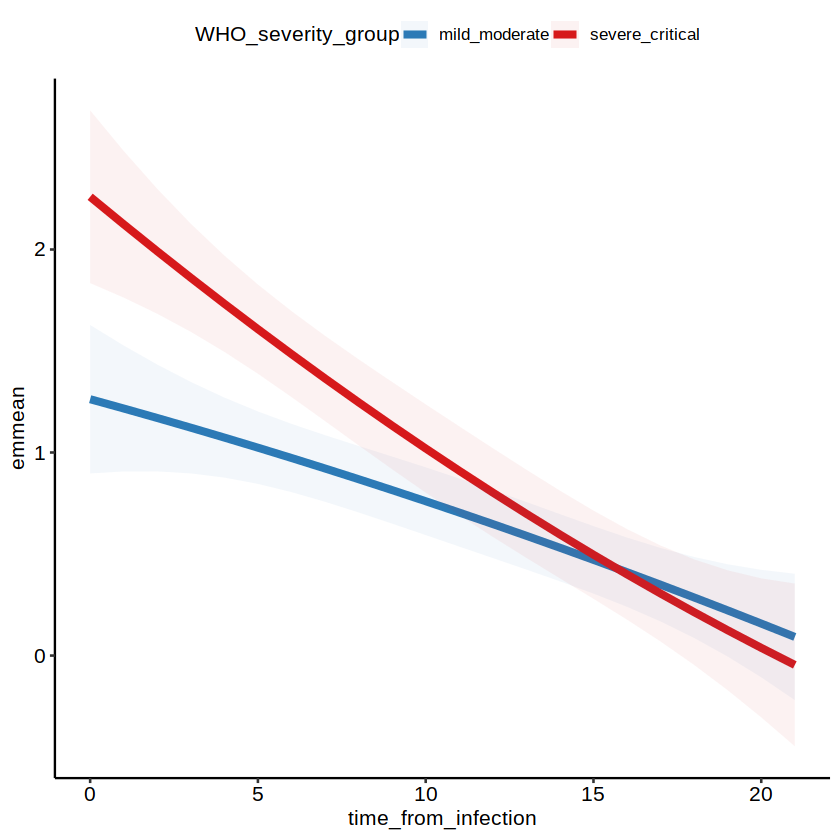

In [17]:
i = 26
x = emmeans(fits[[i]]$fit, ~ time_from_infection | WHO_severity_group, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = WHO_severity_group, fill = WHO_severity_group)) +
    geom_line(aes(colour = WHO_severity_group), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))
ggsave("B_IFNA.pdf")


Saving 6.67 x 6.67 in image



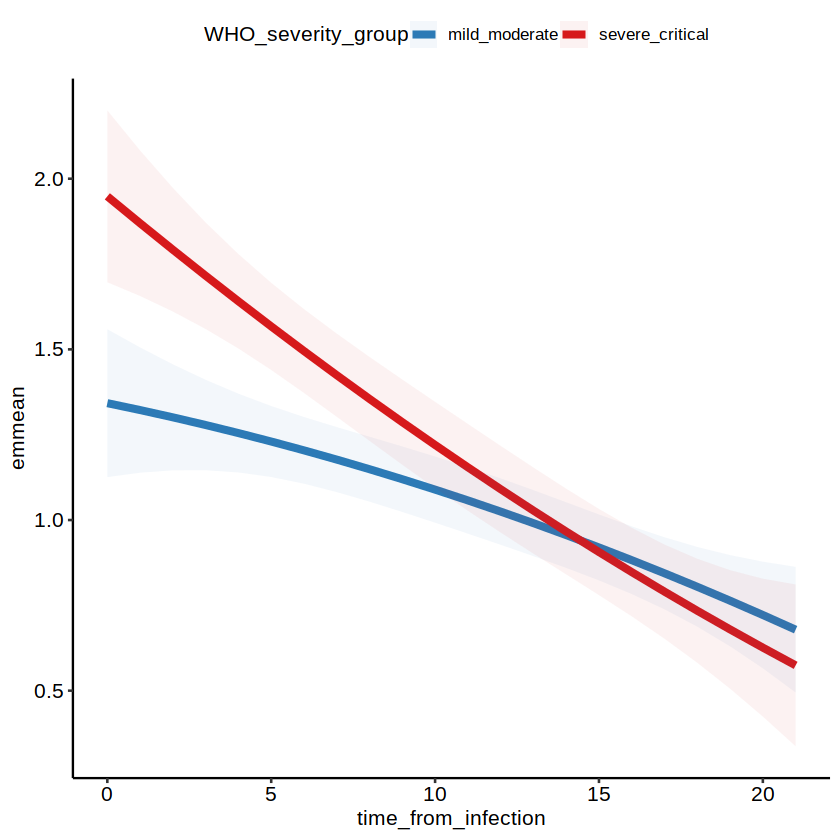

In [18]:
i = 27
x = emmeans(fits[[i]]$fit, ~ time_from_infection | WHO_severity_group, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = WHO_severity_group, fill = WHO_severity_group)) +
    geom_line(aes(colour = WHO_severity_group), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))
ggsave("B_IFNG.pdf")


### KEGG

In [20]:
m <- msigdbr(category = 'C2', subcategory = 'CP:KEGG')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)

In [21]:
seu <- as.Seurat(smrzd)
data <- seu@meta.data
seu <- AddModuleScore(seu, features = genelists, name = names(genelists))

Warning message:
“The following features are not present in the object: G6PC1, TRADD, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: ADSS1, ADSS2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: HLA-DRB3, HLA-DRB4, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: ATP5MC1P5, COX6CP3, UQCR10P1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FCSK, GFUS, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: AARS1, CARS1, DARS1, EPRS1, GARS1, HARS1, IARS1, KARS1, LARS1, MARS1, NARS1, QARS1, RARS1, SARS1, TARS1, TARS3, VARS1, WARS1, YARS1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: GPX1, not searching for symbol synonyms”
Warning message:
“The 

In [22]:
fits <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data$geneset <- seu@meta.data[,x]
    fit <- lmerTest::lmer(fullFormula, data = data)
    return(list(fit=fit, data=data))
})
save(fits,file="KEGG_combined_B_fit.RData")

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



In [23]:
fit_res <- lapply(fits, function(x) anova(x$fit))
singular <- lapply(fits, function(x) as.numeric(isSingular(x$fit)))
conv <- lapply(fits, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals <- lapply(fit_res, function(x) x[8,6])
qvals <- p.adjust(pvals, method = 'BH')
df = data.frame(pvals = unlist(pvals), 
                qvals = unlist(qvals), 
                singular = unlist(singular), 
                conv = unlist(conv), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df$pathway<-rownames(df)
df = df[df$conv == 0,]
head(df)
write.table(df,"KEGG_combined_B_all.tsv",col.names=TRUE,row.names=FALSE,quote=FALSE,sep="\t")

,pvals,qvals,singular,conv,pathway
,<dbl>,<dbl>,<dbl>,<int>,<chr>
KEGG_ABC_TRANSPORTERS1,0.730884540,0.83124194,0,0,KEGG_ABC_TRANSPORTERS1
KEGG_ACUTE_MYELOID_LEUKEMIA2,0.634164224,0.76593861,0,0,KEGG_ACUTE_MYELOID_LEUKEMIA2
KEGG_ADHERENS_JUNCTION3,0.070880161,0.19677179,0,0,KEGG_ADHERENS_JUNCTION3
KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM5,0.603454619,0.74332821,0,0,KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM5
KEGG_ALDOSTERONE_REGULATED_SODIUM_REABSORPTION6,0.364948218,0.55977114,0,0,KEGG_ALDOSTERONE_REGULATED_SODIUM_REABSORPTION6
KEGG_ALLOGRAFT_REJECTION7,0.000328213,0.01119105,0,0,KEGG_ALLOGRAFT_REJECTION7


In [24]:
df = df[df$pvals < 0.05 & df$conv == 0,]
df
df$pathway<-rownames(df)
write.table(df,"KEGG_combined_B_sig.tsv",col.names=TRUE,row.names=FALSE,quote=FALSE,sep="\t")

,pvals,qvals,singular,conv,pathway
,<dbl>,<dbl>,<dbl>,<int>,<chr>
KEGG_ALLOGRAFT_REJECTION7,3.282130e-04,0.011191050,0,0,KEGG_ALLOGRAFT_REJECTION7
KEGG_ASTHMA19,2.987743e-03,0.027786012,0,0,KEGG_ASTHMA19
KEGG_AUTOIMMUNE_THYROID_DISEASE20,2.808732e-04,0.011191050,0,0,KEGG_AUTOIMMUNE_THYROID_DISEASE20
KEGG_AXON_GUIDANCE21,2.592159e-02,0.110446361,0,0,KEGG_AXON_GUIDANCE21
KEGG_B_CELL_RECEPTOR_SIGNALING_PATHWAY22,3.543647e-02,0.122058955,0,0,KEGG_B_CELL_RECEPTOR_SIGNALING_PATHWAY22
KEGG_BASE_EXCISION_REPAIR25,2.416928e-03,0.027786012,0,0,KEGG_BASE_EXCISION_REPAIR25
KEGG_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS27,3.153716e-02,0.115017875,0,0,KEGG_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS27
KEGG_BLADDER_CANCER28,2.800850e-02,0.110446361,0,0,KEGG_BLADDER_CANCER28
KEGG_CALCIUM_SIGNALING_PATHWAY30,1.430311e-02,0.073899411,0,0,KEGG_CALCIUM_SIGNALING_PATHWAY30


### REACTOME

In [25]:
m <- msigdbr(category = 'C2', subcategory = 'CP:REACTOME')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)

In [26]:
seu <- as.Seurat(smrzd)
data <- seu@meta.data
seu <- AddModuleScore(seu, features = genelists, name = names(genelists))

Warning message:
“The following features are not present in the object: H2AB1, H2AC14, H2AC20, H2AC4, H2AC6, H2AC7, H2AC8, H2AJ, H2AX, H2AZ1, H2AZ2, H2BC1, H2BC10, H2BC11, H2BC12, H2BC13, H2BC14, H2BC15, H2BC17, H2BC21, H2BC3, H2BC4, H2BC5, H2BC6, H2BC7, H2BC8, H2BC9, H2BS1, H2BU1, H3-3A, H3-3B, H3C1, H3C10, H3C11, H3C12, H3C13, H3C14, H3C15, H3C2, H3C3, H3C4, H3C6, H3C7, H3C8, H4-16, H4C1, H4C11, H4C12, H4C13, H4C14, H4C15, H4C2, H4C3, H4C4, H4C5, H4C6, H4C8, H4C9, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: TUBB8B, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: H2AB1, H2AC14, H2AC20, H2AC4, H2AC6, H2AC7, H2AC8, H2AJ, H2AX, H2AZ1, H2AZ2, H2BC1, H2BC10, H2BC11, H2BC12, H2BC13, H2BC14, H2BC15, H2BC17, H2BC21, H2BC3, H2BC4, H2BC5, H2BC6, H2BC7, H2BC8, H2BC9, H2BS1, H2BU1, H3-3A, H3-3B, H3C1, H3C10, H3C11, H3C12, H3C13, H3C14, H3C15, H3C2, H3C3, H3C4, H3C6, H3C7, H3C8

In [27]:
fits <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data$geneset <- seu@meta.data[,x]
    fit <- lmerTest::lmer(fullFormula, data = data)
    return(list(fit=fit, data=data))
})
save(fits,file="Reactome_combined_B_fit.RData")

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) 

In [28]:
fit_res <- lapply(fits, function(x) anova(x$fit))
singular <- lapply(fits, function(x) as.numeric(isSingular(x$fit)))
conv <- lapply(fits, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals <- lapply(fit_res, function(x) x[8,6])
qvals <- p.adjust(pvals, method = 'BH')
df = data.frame(pvals = unlist(pvals), 
                qvals = unlist(qvals), 
                singular = unlist(singular), 
                conv = unlist(conv), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df$pathway<-rownames(df)
df = df[df$conv == 0,]
head(df)
write.table(df,"Reactome_combined_B_all.tsv",col.names=TRUE,row.names=FALSE,quote=FALSE,sep="\t")

,pvals,qvals,singular,conv,pathway
,<dbl>,<dbl>,<dbl>,<int>,<chr>
REACTOME_ABACAVIR_TRANSMEMBRANE_TRANSPORT4,0.2026110678,0.46901323,0,0,REACTOME_ABACAVIR_TRANSMEMBRANE_TRANSPORT4
REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT6,0.0030200786,0.04931726,0,0,REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT6
REACTOME_ABC_TRANSPORTER_DISORDERS7,0.0116134851,0.08931323,0,0,REACTOME_ABC_TRANSPORTER_DISORDERS7
REACTOME_ABC_TRANSPORTERS_IN_LIPID_HOMEOSTASIS8,0.3272065981,0.60531347,0,0,REACTOME_ABC_TRANSPORTERS_IN_LIPID_HOMEOSTASIS8
REACTOME_ABERRANT_REGULATION_OF_MITOTIC_EXIT_IN_CANCER_DUE_TO_RB1_DEFECTS9,0.3649687572,0.63584093,0,0,REACTOME_ABERRANT_REGULATION_OF_MITOTIC_EXIT_IN_CANCER_DUE_TO_RB1_DEFECTS9
REACTOME_ABERRANT_REGULATION_OF_MITOTIC_G1_S_TRANSITION_IN_CANCER_DUE_TO_RB1_DEFECTS10,0.0005970806,0.03110597,0,0,REACTOME_ABERRANT_REGULATION_OF_MITOTIC_G1_S_TRANSITION_IN_CANCER_DUE_TO_RB1_DEFECTS10


In [29]:
df = df[df$pvals < 0.05 & df$conv == 0,]
df
df$pathway<-rownames(df)
write.table(df,"Reactome_combined_B_sig.tsv",col.names=TRUE,row.names=FALSE,quote=FALSE,sep="\t")

,pvals,qvals,singular,conv,pathway
,<dbl>,<dbl>,<dbl>,<int>,<chr>
REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT6,0.0030200786,0.04931726,0,0,REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT6
REACTOME_ABC_TRANSPORTER_DISORDERS7,0.0116134851,0.08931323,0,0,REACTOME_ABC_TRANSPORTER_DISORDERS7
REACTOME_ABERRANT_REGULATION_OF_MITOTIC_G1_S_TRANSITION_IN_CANCER_DUE_TO_RB1_DEFECTS10,0.0005970806,0.03110597,0,0,REACTOME_ABERRANT_REGULATION_OF_MITOTIC_G1_S_TRANSITION_IN_CANCER_DUE_TO_RB1_DEFECTS10
REACTOME_ACETYLCHOLINE_REGULATES_INSULIN_SECRETION15,0.0085351161,0.07613755,0,0,REACTOME_ACETYLCHOLINE_REGULATES_INSULIN_SECRETION15
REACTOME_ACTIVATION_OF_ATR_IN_RESPONSE_TO_REPLICATION_STRESS29,0.0044312853,0.05950683,0,0,REACTOME_ACTIVATION_OF_ATR_IN_RESPONSE_TO_REPLICATION_STRESS29
REACTOME_ACTIVATION_OF_IRF3_IRF7_MEDIATED_BY_TBK1_IKK_EPSILON35,0.0356611240,0.17323970,0,0,REACTOME_ACTIVATION_OF_IRF3_IRF7_MEDIATED_BY_TBK1_IKK_EPSILON35
REACTOME_ACTIVATION_OF_NIMA_KINASES_NEK9_NEK6_NEK738,0.0452959608,0.19200256,0,0,REACTOME_ACTIVATION_OF_NIMA_KINASES_NEK9_NEK6_NEK738
REACTOME_ACTIVATION_OF_THE_AP_1_FAMILY_OF_TRANSCRIPTION_FACTORS47,0.0027508539,0.04931726,0,0,REACTOME_ACTIVATION_OF_THE_AP_1_FAMILY_OF_TRANSCRIPTION_FACTORS47
REACTOME_ACTIVATION_OF_THE_PRE_REPLICATIVE_COMPLEX50,0.0023268132,0.04817697,0,0,REACTOME_ACTIVATION_OF_THE_PRE_REPLICATIVE_COMPLEX50
